In [ ]:
directory = '../data_users/'
import zipfile
with zipfile.ZipFile(directory+'ecg_ppg_25_left1.zip', 'r') as zip_ref:
    zip_ref.extractall(directory+'ecg_ppg_25_left1')

In [50]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.externals.joblib import Parallel,delayed

def get_rr_fixed(a,n=3):
    n_remain = 60 - a.shape[0]
    for i in range(n):
        a[np.where((a[:,i]<300)|(a[:,i]>1500))[0],i] = np.nanmedian(a[:,i])
        a[np.isnan(a[:,i]),i] = np.nanmedian(a[:,i])
    if n_remain==0:
        return a
    median_value = np.nanmedian(a,axis=0).reshape(-1,n)
    t = np.concatenate([median_value]*n_remain)
    return np.concatenate([a,t],axis=0)

def get_qual_fixed(a,n=3):
    n_remain = 60 - a.shape[0]
    if n_remain==0:
        return a
    for i in range(n):
        a[np.isnan(a[:,i]),i] = np.nanmedian(a[:,i])
    median_value = np.nanmedian(a,axis=0).reshape(-1,n)
    t = np.concatenate([median_value]*n_remain)
    return np.concatenate([a,t],axis=0)
    
def fix_likelihood(a):
    a[a<.1] = .1
    return a
def parse_each_participant(directory,d):
    data = pickle.load(open(directory+d,'rb')).reset_index(drop=True)
    data['rr_array_tmp'] = data['rr_array'].apply(lambda a:a.reshape(-1))
    data['tmp'] = data['rr_array_tmp'].apply(lambda a:len(a[np.where((a>300)&(a<1500))[0]]))
    data = data[data.tmp>150]
    data['likelihood_max_array'] = data['likelihood_max_array'].apply(lambda a:get_qual_fixed(a))
    data['activity'] = data['activity'].apply(lambda a:get_qual_fixed(np.array(a).reshape(-1,1),1))
    data['likelihood'] = data['likelihood_max_array'].apply(lambda a:np.max(a,axis=1).reshape(-1,1))
    data['rr_array'] = data['rr_array'].apply(lambda a:get_rr_fixed(a))
    data['likelihood_ind'] = data['likelihood_max_array'].apply(lambda a:np.argmax(a,axis=1))
    indexes = data['likelihood_ind'].values
    rr_arrays = data['rr_array'].values
    rrs = []
    for i,rr in enumerate(rr_arrays):
        index = indexes[i]
        frr = np.squeeze(np.array([rr[i,index[i]] for i in range(rr.shape[0])]))
        rrs.append(frr.reshape(-1,1))
    data['rr'] = rrs
    data['x'] = data.apply(lambda a: np.concatenate([a['rr_array'],a['likelihood_max_array'],a['activity']],axis=1),
                     axis=1)
    data['y'] = data.apply(lambda a: np.concatenate([a['rr'],fix_likelihood(a['likelihood'])],axis=1),
                     axis=1)
    pickle.dump(data,open(directory1+d,'wb'))
    return []

directory = '../data_users/ecg_ppg_25_left1/'
directory1 = '../data_users/ecg_ppg_25_left2/'
a = Parallel(n_jobs=5,verbose=2)(delayed(parse_each_participant)(directory,d) for d in os.listdir(directory) if d[-1]=='p')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   32.1s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  1.1min finished


In [51]:
import pickle
import numpy as np
import pandas as pd
import os
from sklearn.externals.joblib import Parallel,delayed
def get_training_data(directory,d):
    data = pickle.load(open(directory+d,'rb')).reset_index(drop=True)
    X = np.array(list(data['x'].values))
    y = np.array(list(data['y'].values))
    return X,y
directory1 = '../data_users/ecg_ppg_25_left2/'
data = Parallel(n_jobs=10,verbose=2)(delayed(get_training_data)(directory1,d) for d in list(os.listdir(directory1))[:30] if d[-1]=='p')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:    4.6s remaining:    0.4s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:    5.7s finished


In [52]:
X = np.concatenate([a[0] for a in data])
y = np.concatenate([a[1] for a in data])
print(X.shape,y.shape)

(98140, 60, 7) (98140, 60, 2)


In [98]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test1 = train_test_split(X[:,:,:-1], y, test_size=0.1, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)
print(X_train.shape,y_train.shape,y_test.shape,y_val.shape)

(70660, 60, 6) (70660, 60, 2) (9814, 60) (17666, 60, 2)


In [103]:
def meanabserror(y_true,y_pred):
    diff = K.abs((y_true - y_pred))
    return K.mean(diff, axis=-1)

def custom_mae(y_true,y_pred):
    weights = y_true[:,:,1]
    y_true = y_true[:,:,0]
    y_pred = y_pred[:,:,0]
    y_true = K.cast(y_true, y_pred.dtype)
    diff = K.abs((y_true - y_pred)
                 / K.clip(K.abs(y_true),K.epsilon(),None))
    diff = diff*weights
    return 100*K.mean(K.mean(diff, axis=-1)) + losses.mean_absolute_error(y_true,y_pred)
#     return losses.mean_absolute_error(y_true,y_pred)

timesteps = 60
input_dim = 6
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = Flatten()(mer)
encoded = Dense(40,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
encoded = RepeatVector(2)(encoded)
encoded = Permute((2,1))(encoded)
sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded])
sequence_autoencoder.compile(optimizer='adam',loss=custom_mae)
sequence_autoencoder.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 60, 6)        0                                            
__________________________________________________________________________________________________
bidirectional_10 (Bidirectional (None, 60, 120)      24120       input_10[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 60, 1)        121         bidirectional_10[0][0]           
__________________________________________________________________________________________________
flatten_19 (Flatten)            (None, 60)           0           dense_10[0][0]                   
___________________________________________________________________________________________

In [ ]:
filepath = '../models/base_LSTM_weighting_for_stress2.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True,save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=300,
                batch_size=2000,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 70660 samples, validate on 17666 samples
Epoch 1/300
70660/70660 [==============================] - 20s 279us/step - loss: 575.1201 - val_loss: 303.1197

Epoch 00001: val_loss improved from inf to 303.11966, saving model to ../models/base_LSTM_weighting_for_stress2.hdf5
Epoch 2/300
70660/70660 [==============================] - 18s 259us/step - loss: 206.0186 - val_loss: 177.0251

Epoch 00002: val_loss improved from 303.11966 to 177.02511, saving model to ../models/base_LSTM_weighting_for_stress2.hdf5
Epoch 3/300
70660/70660 [==============================] - 19s 267us/step - loss: 173.6759 - val_loss: 169.2567

Epoch 00003: val_loss improved from 177.02511 to 169.25669, saving model to ../models/base_LSTM_weighting_for_stress2.hdf5
Epoch 4/300
70660/70660 [==============================] - 18s 258us/step - loss: 165.2431 - val_loss: 164.2092

Epoch 00004: val_loss improved from 169.25669 to 164.20922, saving model to ../models/base_LSTM_weighting_for_stress2.hdf5
Epoch 5/300


In [99]:
y_pred1 = sequence_autoencoder.predict(X_test)

In [100]:
model_json = sequence_autoencoder.to_json()
with open('../models/model2.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
sequence_autoencoder.save_weights(filepath)

In [101]:
y_pred = y_pred1[:,:,0].reshape(-1,60)
qual = y_test1[:,:,1].reshape(-1,60)
y_test = y_test1[:,:,0].reshape(-1,60)


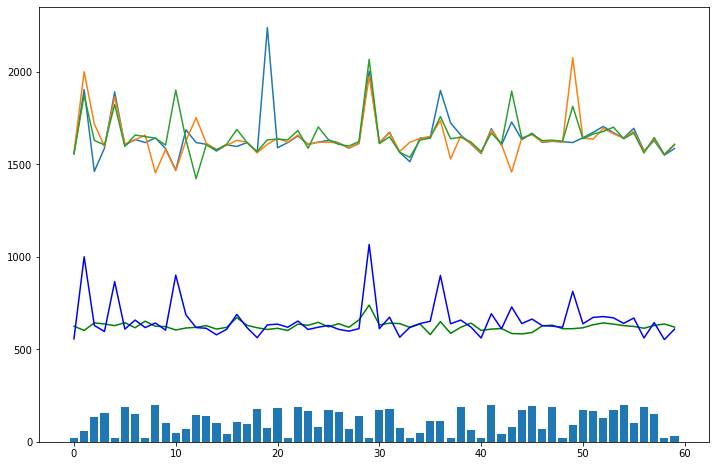

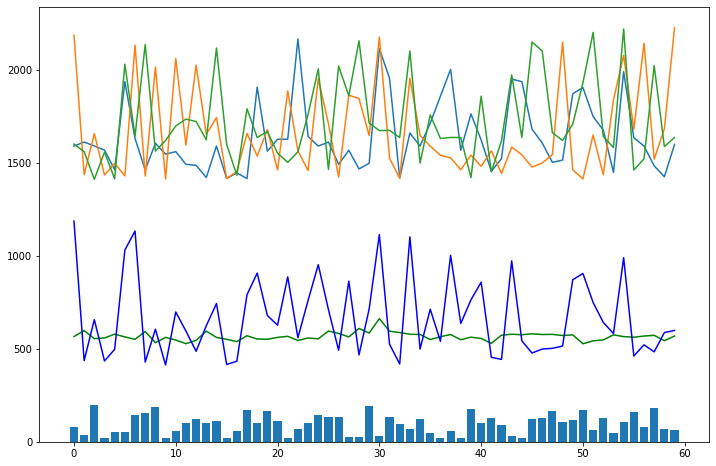

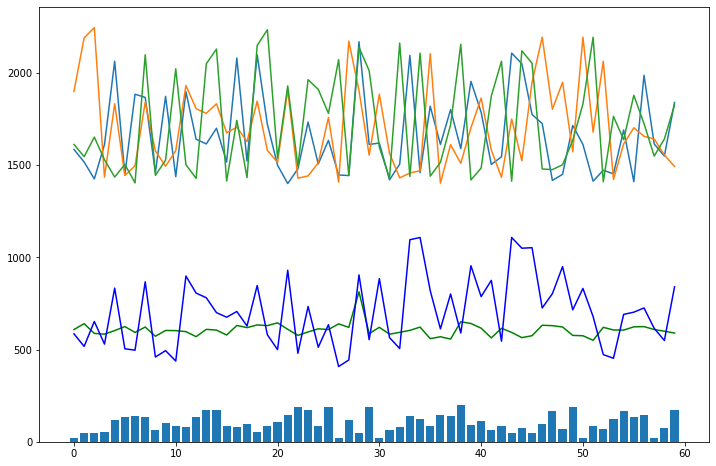

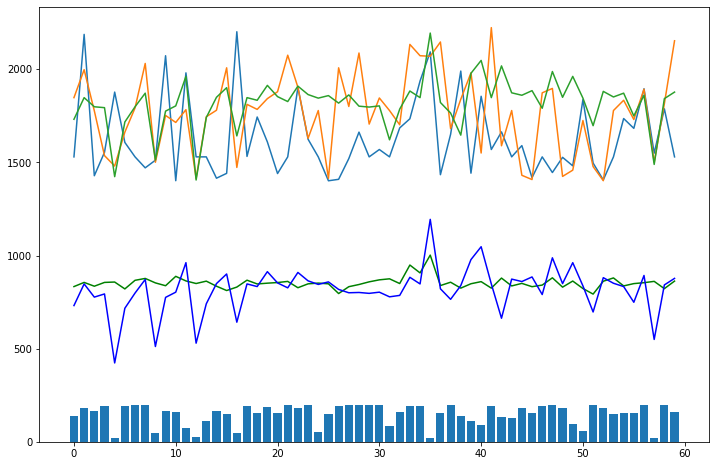

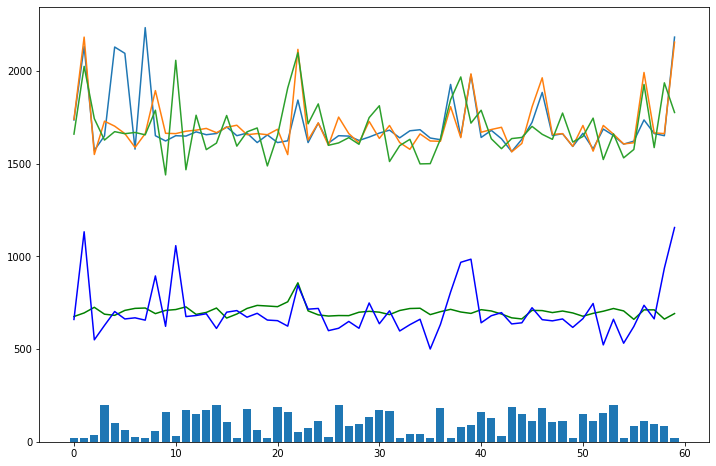

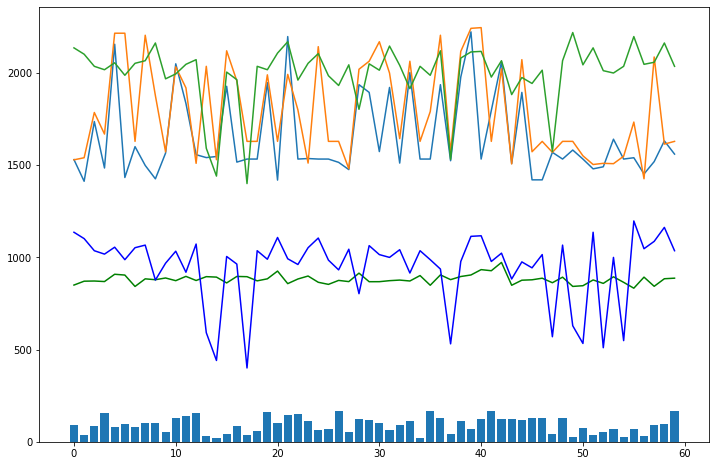

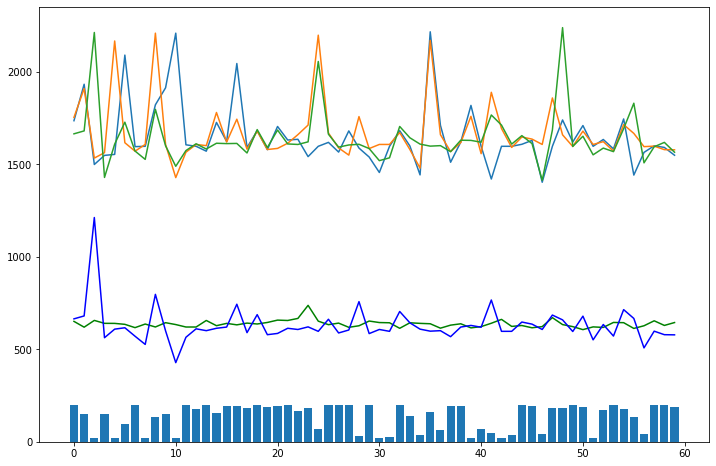

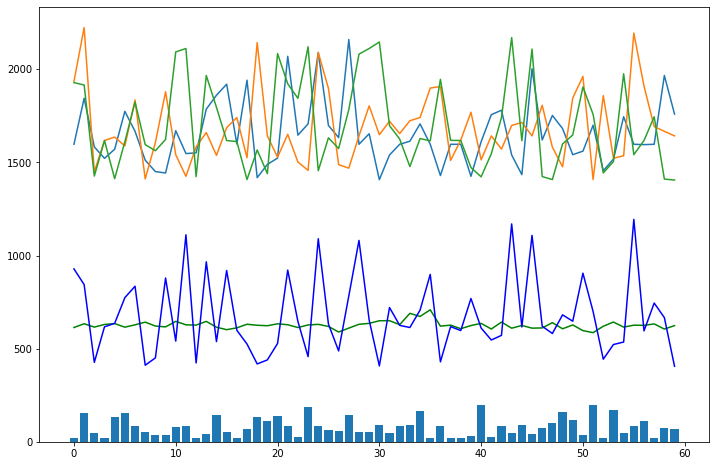

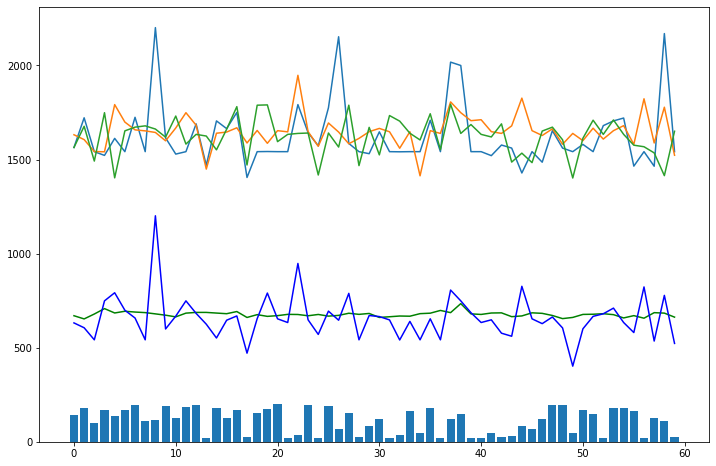

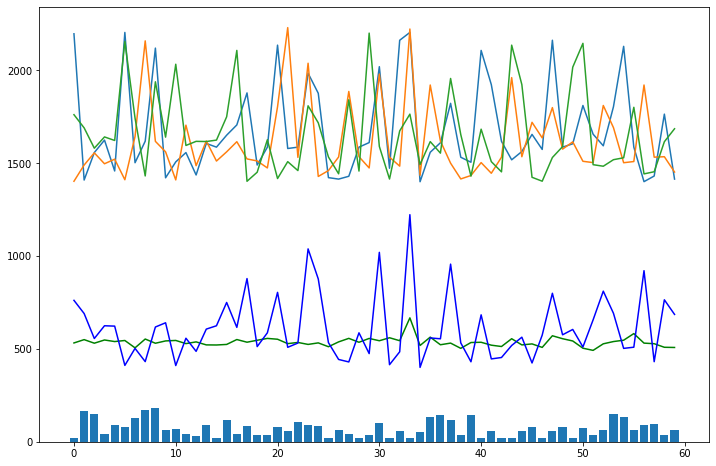

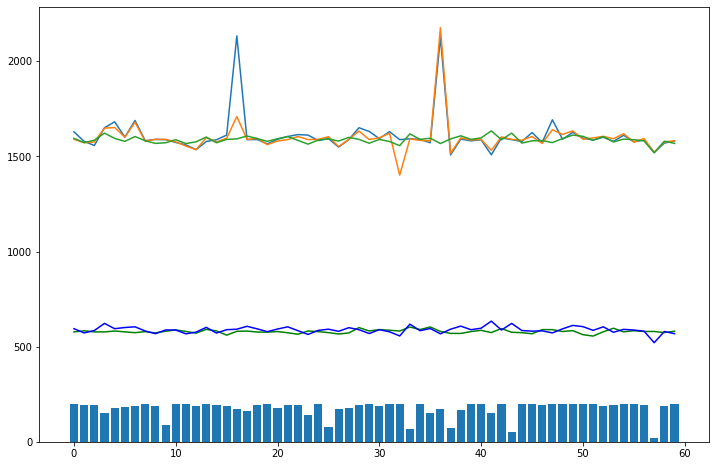

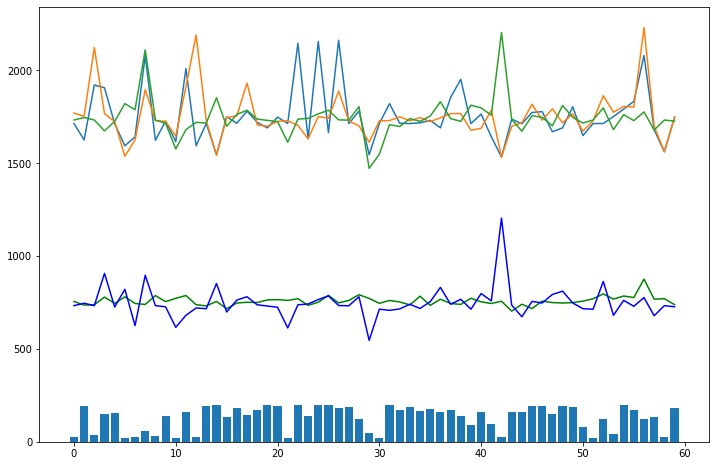

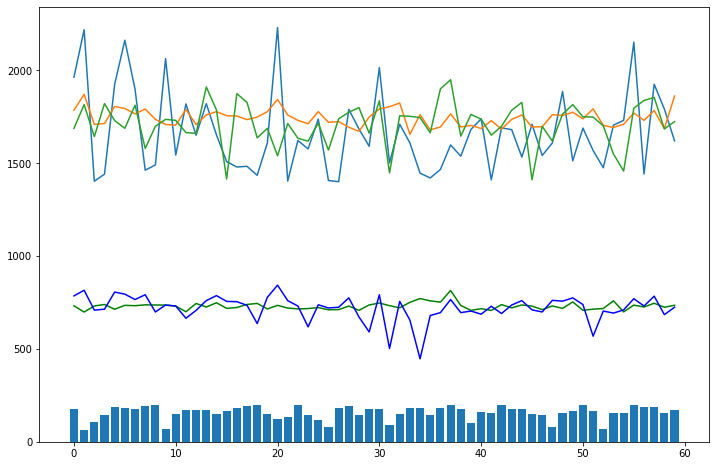

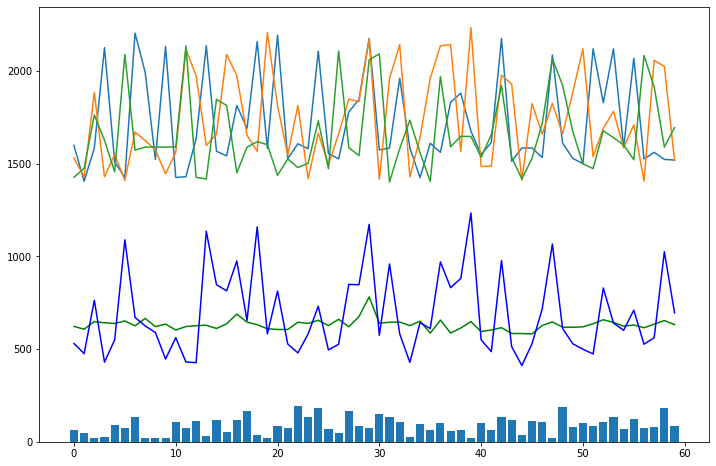

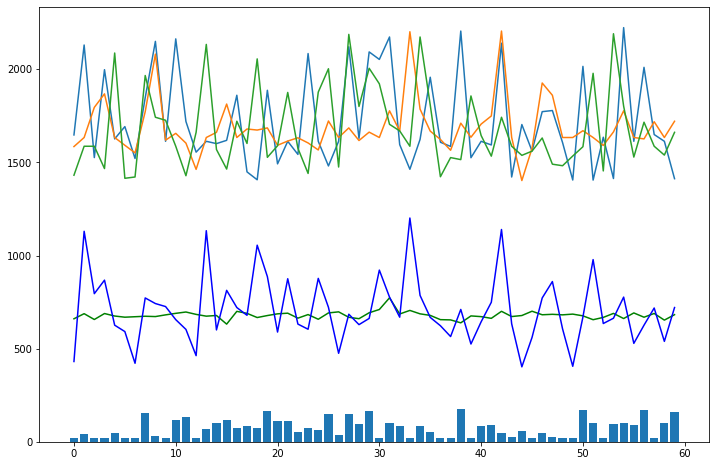

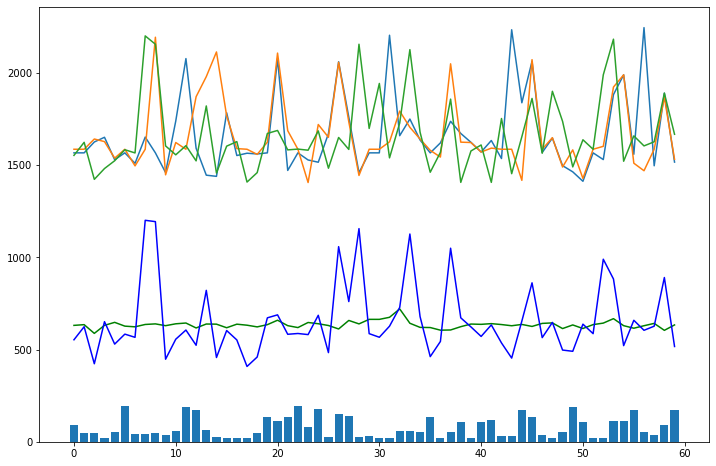

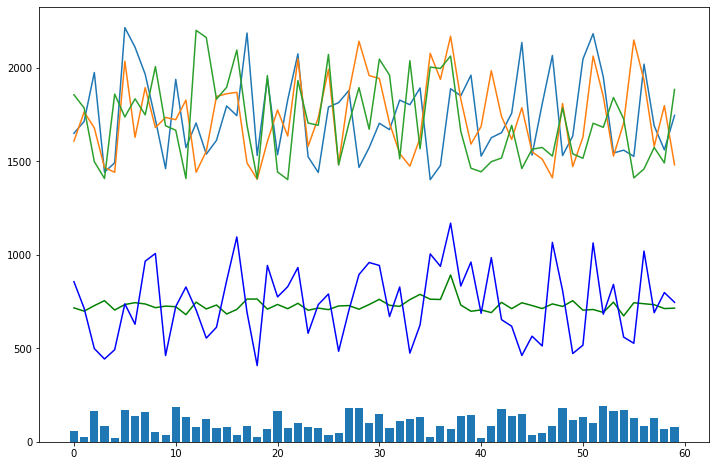

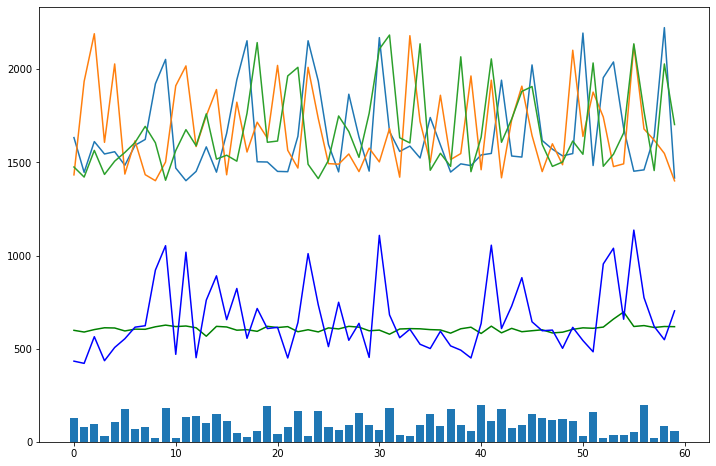

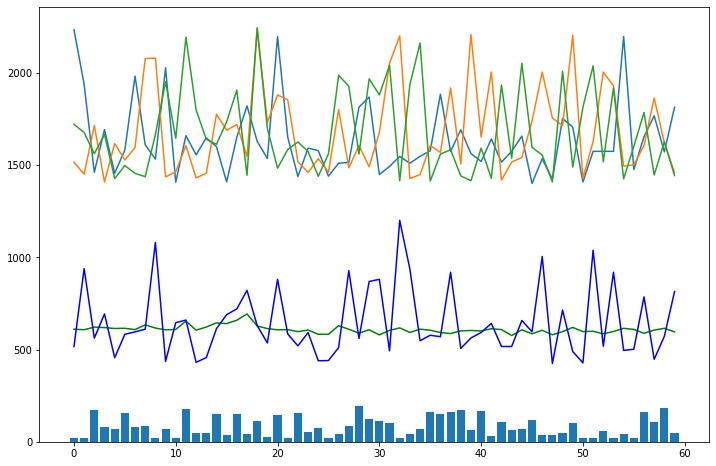

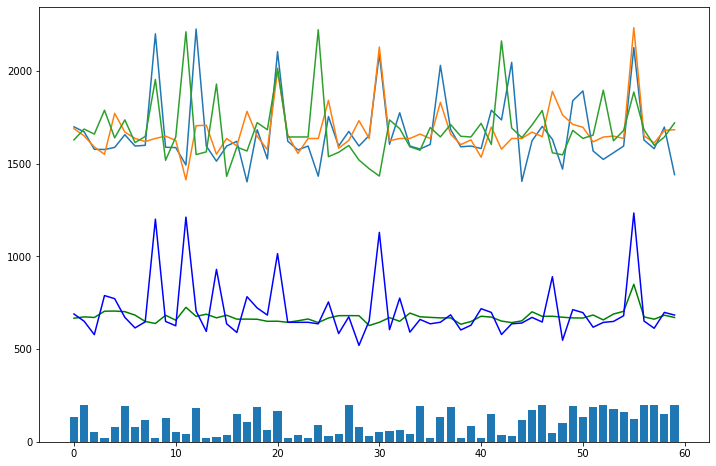

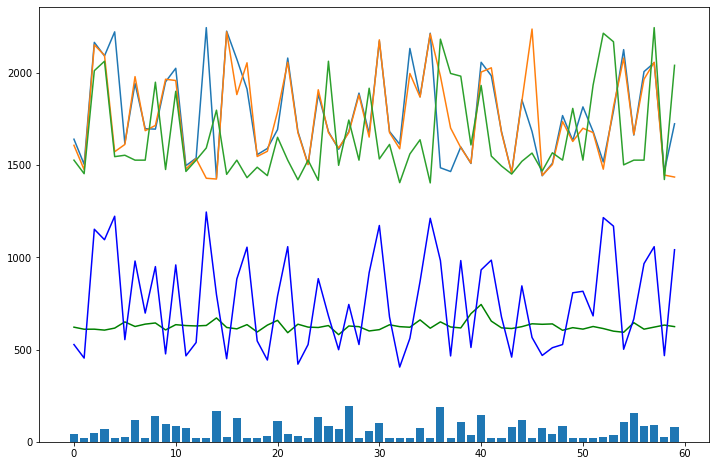

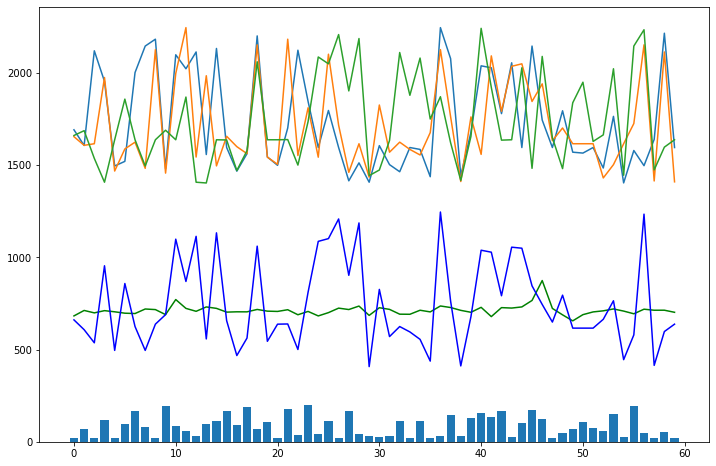

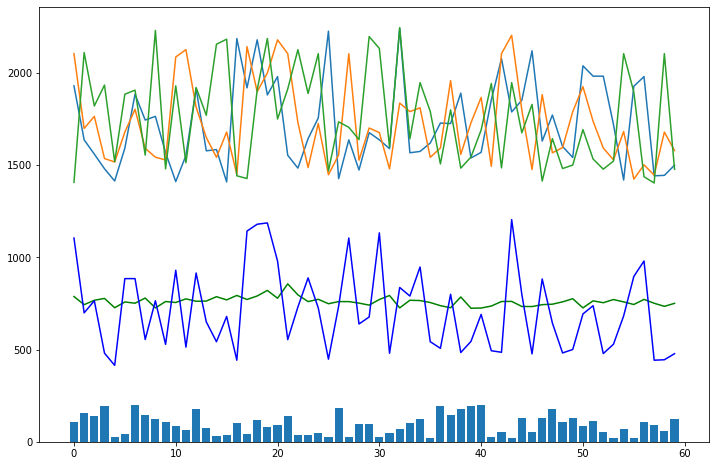

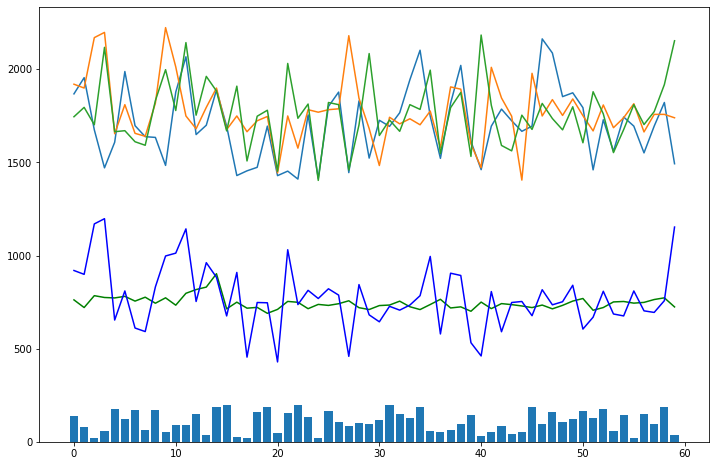

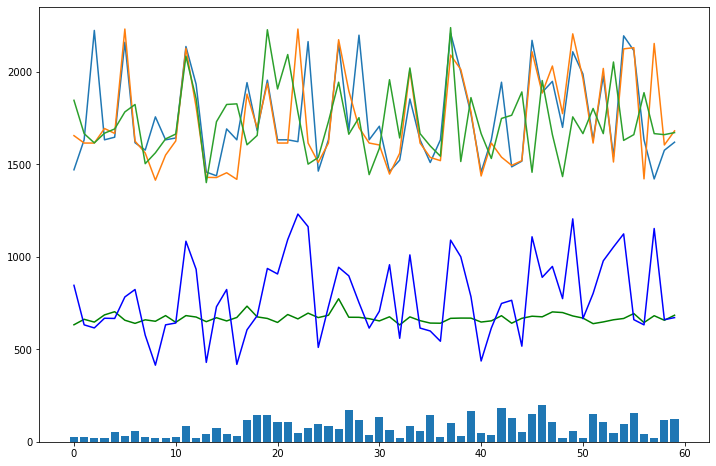

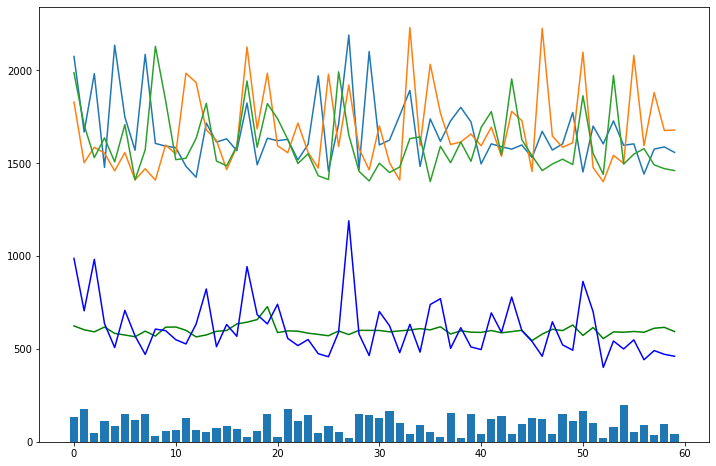

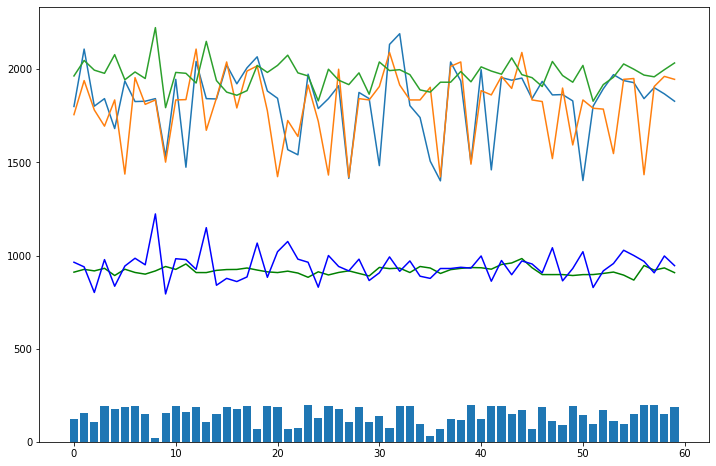

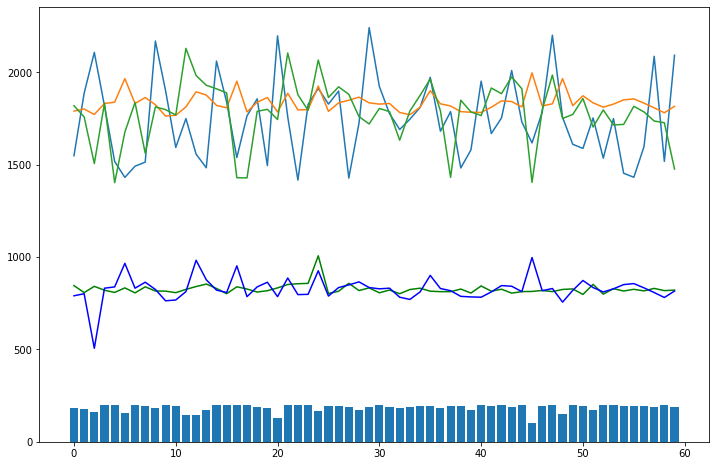

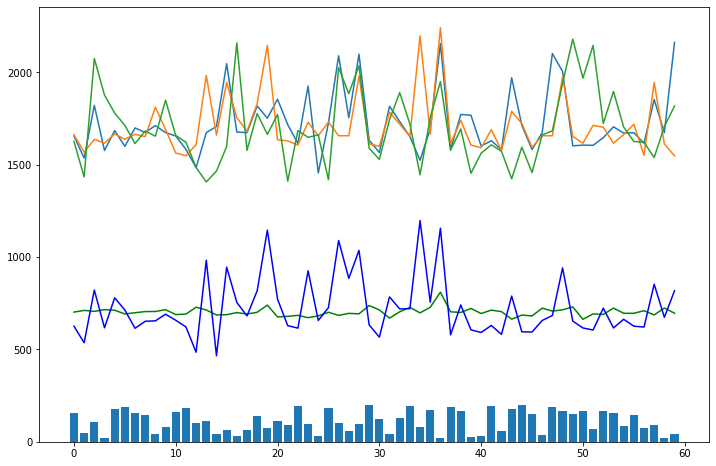

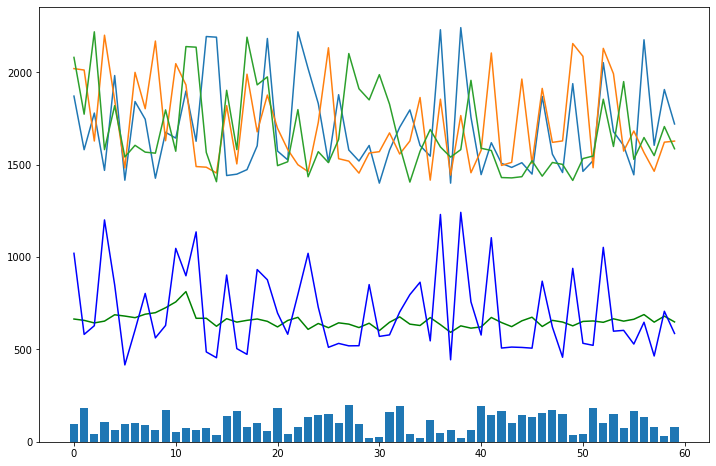

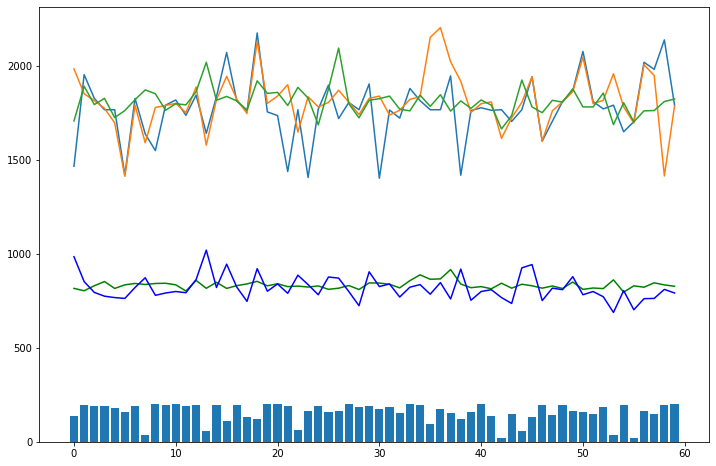

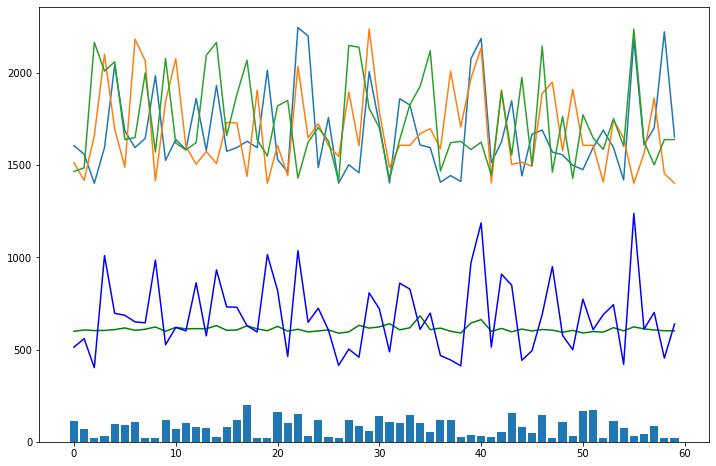

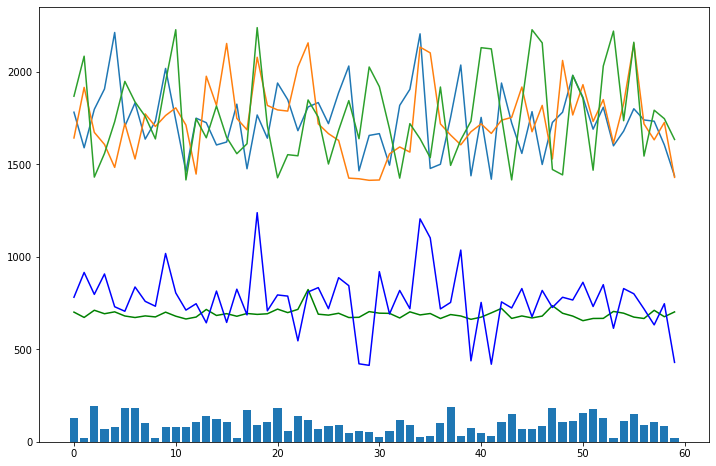

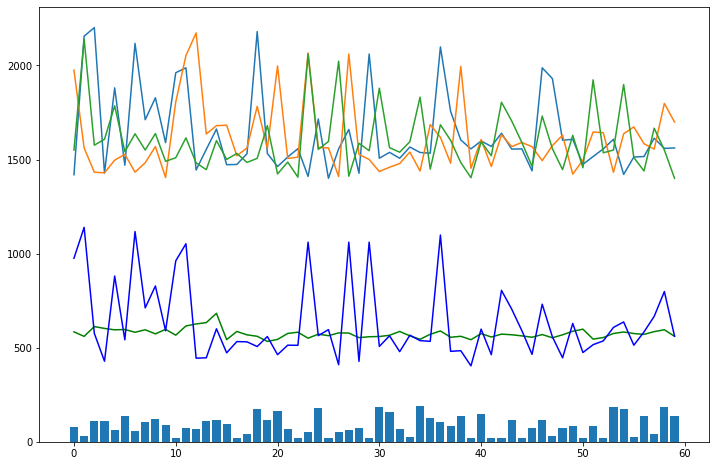

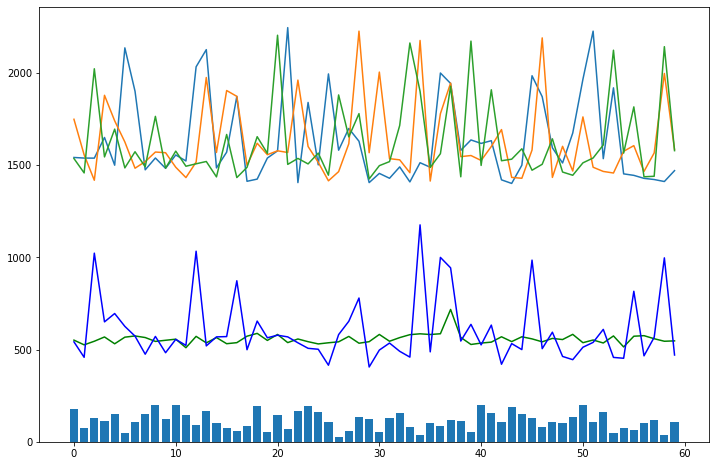

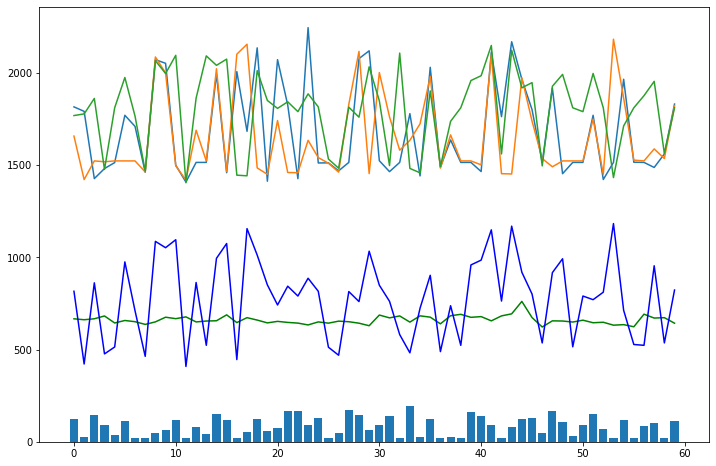

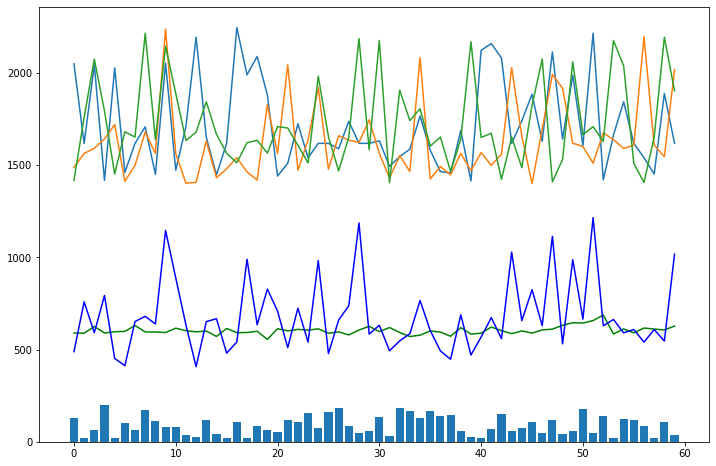

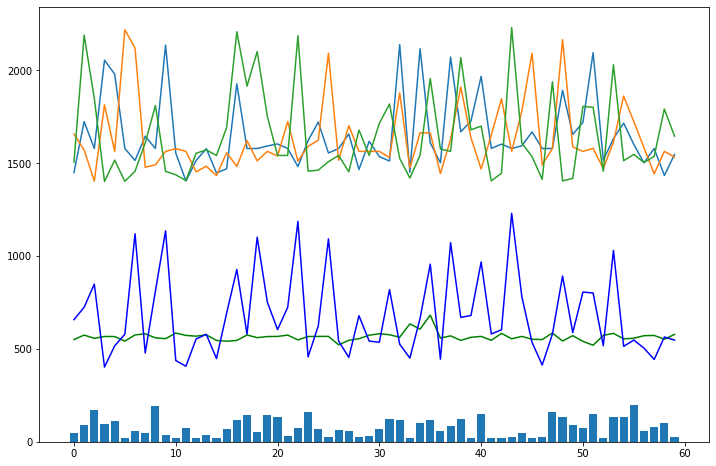

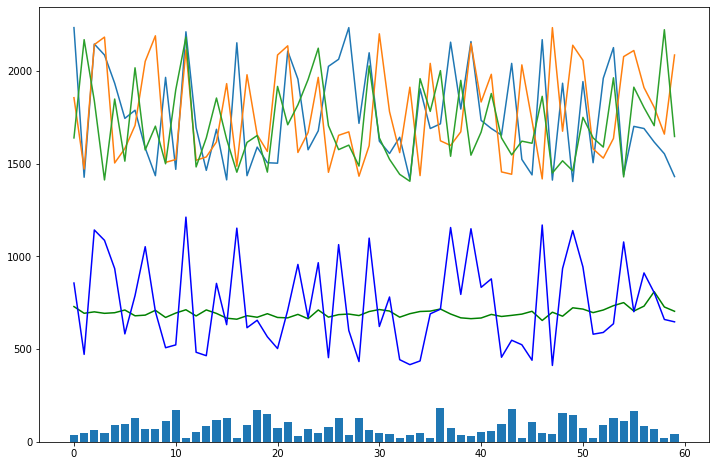

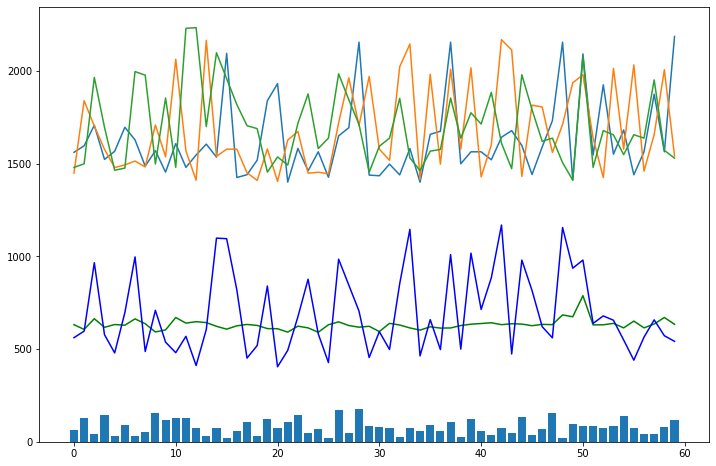

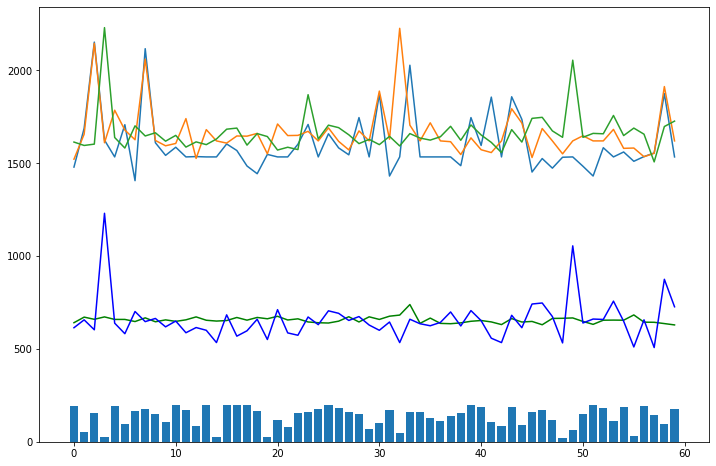

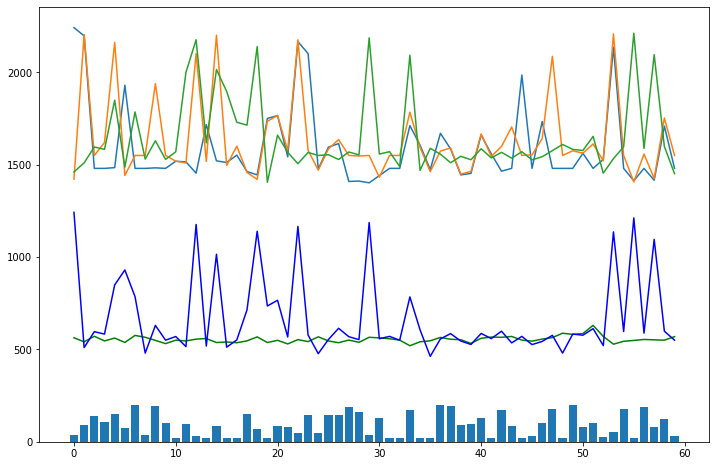

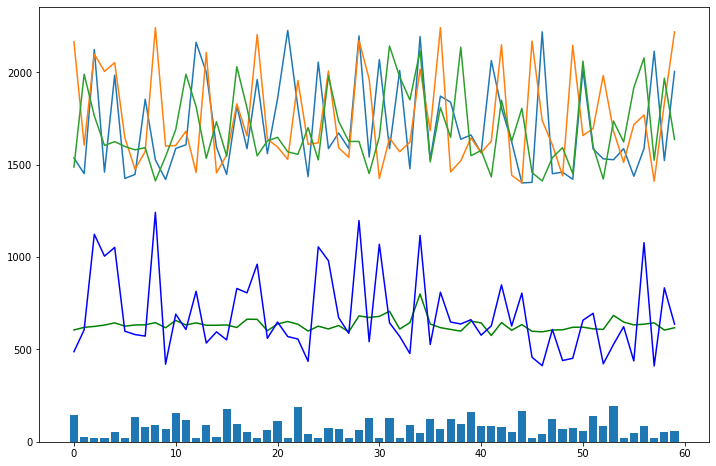

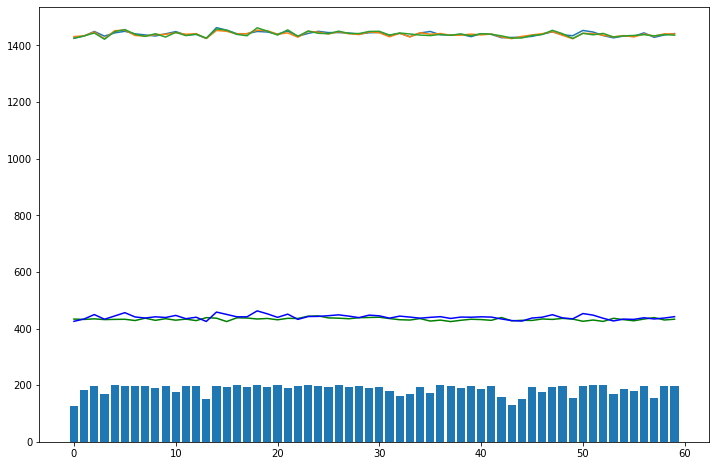

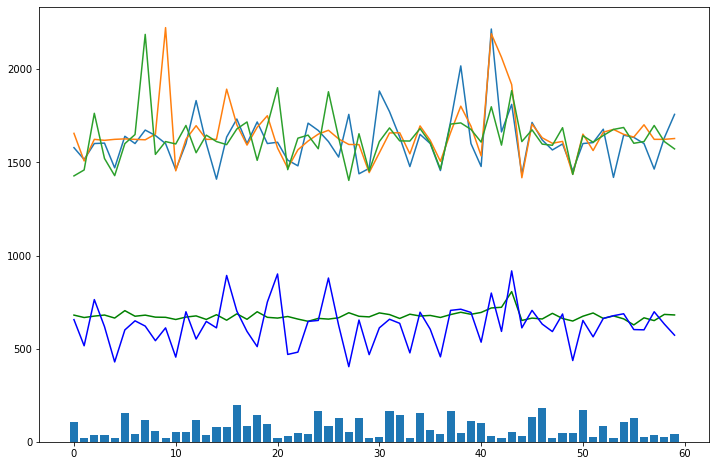

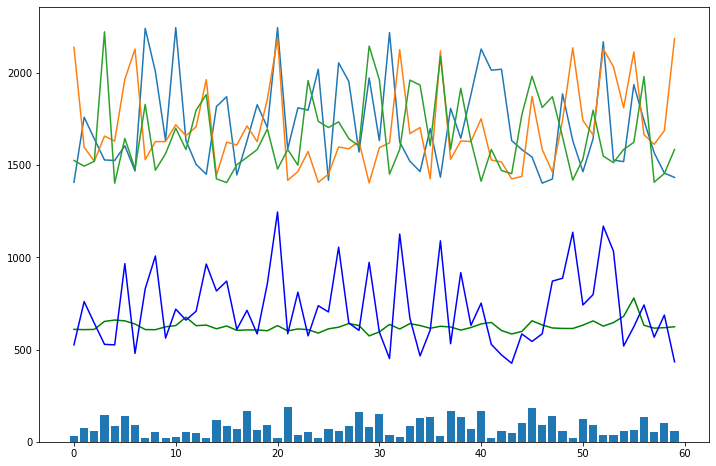

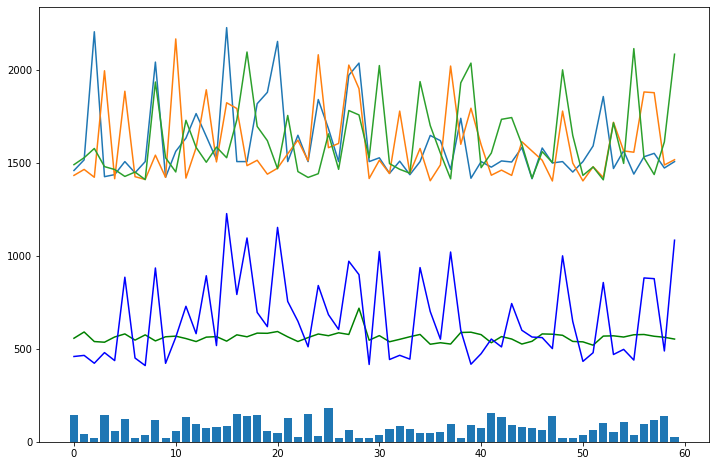

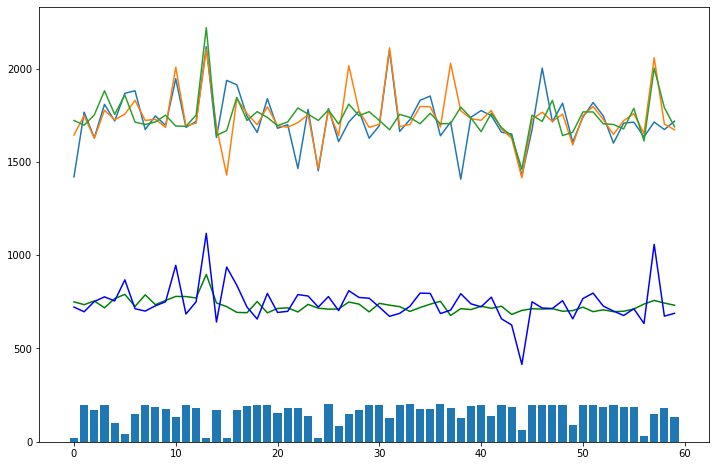

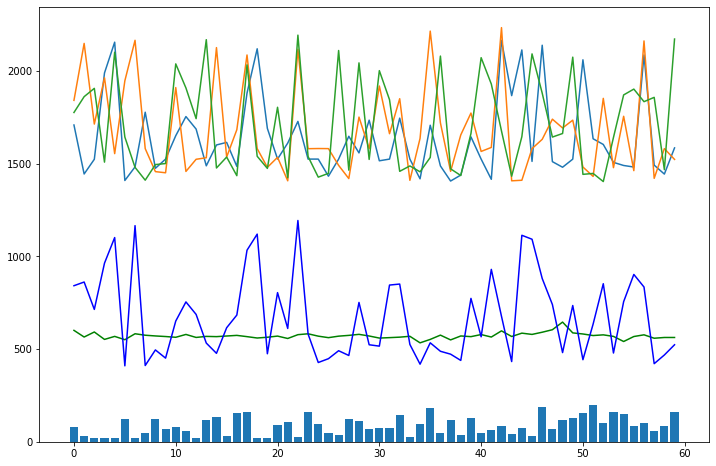

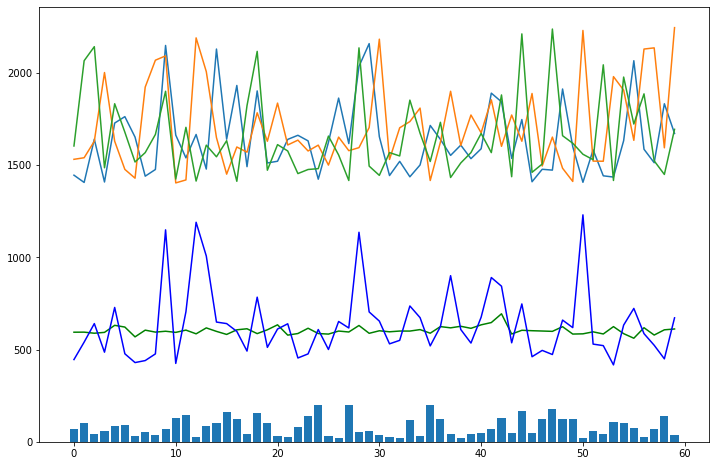

In [102]:
%matplotlib  inline
import matplotlib.pyplot as plt
for i,a in enumerate(y_pred[:50]):
    plt.figure(figsize=(12,8))
    plt.plot(a,'g')
    plt.plot(X_test[i,:,:3]+1000)
    plt.plot(y_test[i],'b')
    plt.bar(range(60),qual[i]*200)
    plt.show()

In [92]:
K.variable(tf.zeros((1,2)))*K.variable(tf.ones((1,2)))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 0.]], dtype=float32)>